In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from information_estimation import *
from image_utils import *
from gaussian_process_utils import *

from led_array.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

Opening BSCCM
Opened BSCCM


In [2]:
def plot_loss_history(train_loss_history, val_loss_history):

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].semilogy(train_loss_history, '-o', label='train')
    axs[0].legend()
    axs[0].set(xlim=[0, len(train_loss_history)], xlabel='iteration', ylabel='Negative log likelihood')

    axs[1].semilogy(val_loss_history, '-o', label='validation', color=get_color_cycle()[1])

    # ylim are 2x the range of the middle 80% of the data
    ylim = onp.percentile(val_loss_history, [10, 90])
    diff = ylim[1] - ylim[0]
    ylim = [ylim[0] - diff, ylim[1] + diff]
    axs[2].semilogy(val_loss_history, '-o', label='validation', color=get_color_cycle()[1])
    axs[2].set_ylim(ylim)
    axs[2].legend()

    for a in axs:
        clear_spines(a)

def plot_and_print_analysis(initial_likelihood, optimized_likelihood, overfit_likelihood,
                            samples_initial, samples_optimized, samples_overfit, 
                            cov_mat_initial, cov_mat_optimized, final_cov_mat, patch_size, num_samples, prefer_iterative_sampling):

    print(f'Initial likelihood: {initial_likelihood}')
    print(f'Optimized likelihood: {optimized_likelihood}')
    print(f'Overfit likelihood: {overfit_likelihood}')


    fig, axs = plt.subplots(3, num_samples, figsize=(num_samples * 3, 6), sharex=True, sharey=True)
    vmin_optimized, vmax_optimized = np.percentile(samples_optimized, .1), np.percentile(samples_optimized, 99.9)
    for i in range(num_samples):
        im1 = axs[0, i].imshow(samples_initial[i], cmap='inferno', vmin=vmin_optimized, vmax=vmax_optimized)
        im2 = axs[1, i].imshow(samples_optimized[i], cmap='inferno', vmin=vmin_optimized, vmax=vmax_optimized)
        im3 = axs[2, i].imshow(samples_overfit[i], cmap='inferno', vmin=vmin_optimized, vmax=vmax_optimized)
        axs[0, i].axis('off')
        axs[1, i].axis('off')
        axs[2, i].axis('off')

    axs[0, 0].set_title('Initial')
    axs[1, 0].set_title('Optimized')
    axs[2, 0].set_title('Overfit')

    # add colorbar
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    fig.colorbar(im1, cax=cbar_ax)
    cbar_ax.set_ylabel('Photons')

    sample_size = samples_optimized.shape[1] * samples_optimized.shape[2]
    fig.suptitle(f'Sample size: {sample_size}, patch_size: {patch_size}, prefer iterative: {prefer_iterative_sampling}')


    # plot eignevalues of different cov mats
    eig_vals_initial = np.linalg.eigvalsh(cov_mat_initial)
    eig_vals_optimized = np.linalg.eigvalsh(cov_mat_optimized)
    eig_vals_overfit = np.linalg.eigvalsh(final_cov_mat)

    fig, axs = plt.subplots(1, 1, figsize=(4, 4))
    axs.semilogy(eig_vals_initial, label='initial')
    axs.semilogy(eig_vals_optimized, label='optimized')
    axs.semilogy(eig_vals_overfit, label='overfit (no early stopping)')
    axs.legend()

    clear_spines(axs)
    axs.set_xlabel('Eigenvalue index')
    axs.set_ylabel('Eigenvalue')

In [3]:
# load images, extract patches, and compute cov mats
edge_crop = 32
patch_size = 10
num_images = 20000
channel = 'LED119'
eigenvalue_floor = 1e-3

num_test_images = 1000

all_images = load_bsccm_images(bsccm, channel=channel, num_images=num_images + num_test_images, edge_crop=edge_crop, median_filter=False)
images = all_images[:num_images]
test_images = all_images[num_images:]
test_patches = extract_patches(test_images, patch_size, num_patches=num_test_images, seed=0)

num_patches = 10000 
seed = 10 # this seed gives a bad initial fit
patches = extract_patches(images, patch_size, num_patches=num_patches, seed=seed)


In [4]:
### Do the optimization
cov_mat_optimized, cov_mat_initial, mean_vec, best_loss, train_loss_history, val_loss_history, final_cov_mat = run_optimization(
    patches, max_iters=1500, return_final=True, patience=150)

Initial loss:  686047.1147863457


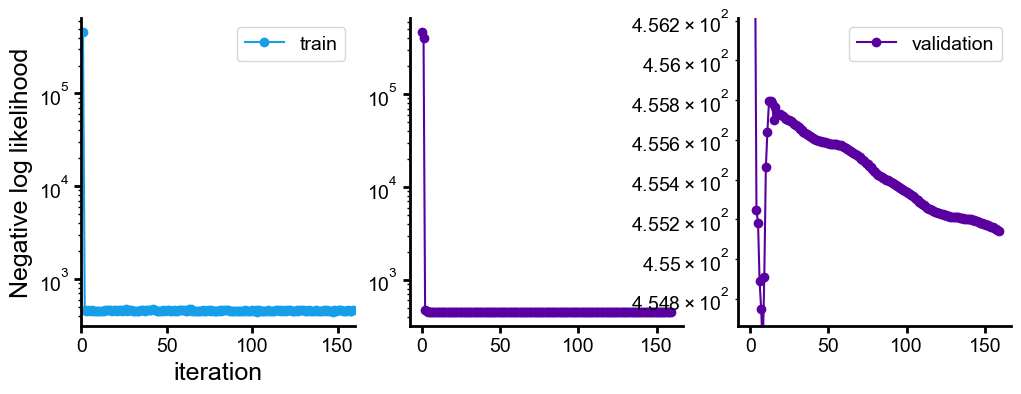

In [5]:
plot_loss_history(train_loss_history, val_loss_history)

In [6]:
sample_size = 40
num_samples = 8
prefer_iterative_sampling = False

samples_initial = generate_stationary_gaussian_process_samples(mean_vec, cov_mat_initial, num_samples=num_samples, sample_size=sample_size, 
        prefer_iterative_sampling=prefer_iterative_sampling, seed=None)
samples_optimized = generate_stationary_gaussian_process_samples(mean_vec, cov_mat_optimized, num_samples=num_samples, sample_size=sample_size,
        prefer_iterative_sampling=prefer_iterative_sampling,  seed=None)
samples_overfit = generate_stationary_gaussian_process_samples(mean_vec, final_cov_mat, num_samples=num_samples, sample_size=sample_size,
        prefer_iterative_sampling=prefer_iterative_sampling,  seed=None)

optimized_likelihood = compute_stationary_log_likelihood(test_patches, cov_mat_optimized, mean_vec).mean()
initial_likelihood = compute_stationary_log_likelihood(test_patches, cov_mat_initial, mean_vec).mean()
overfit_likelihood = compute_stationary_log_likelihood(test_patches, final_cov_mat, mean_vec).mean()

precomputing masks and variances: 100%|██████████| 40/40 [00:49<00:00,  1.23s/it]


generating samples


precomputing masks and variances: 100%|██████████| 40/40 [00:29<00:00,  1.38it/s]


generating samples


precomputing masks and variances: 100%|██████████| 40/40 [00:29<00:00,  1.37it/s]


generating samples


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 193.07it/s]


evaluating likelihood


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 165.57it/s]


evaluating likelihood


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 235.67it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 10/10 [00:00<00:00, 235.38it/s]


Initial likelihood: -614612.096021153
Optimized likelihood: -456.89266095620184
Overfit likelihood: -457.33453338011066


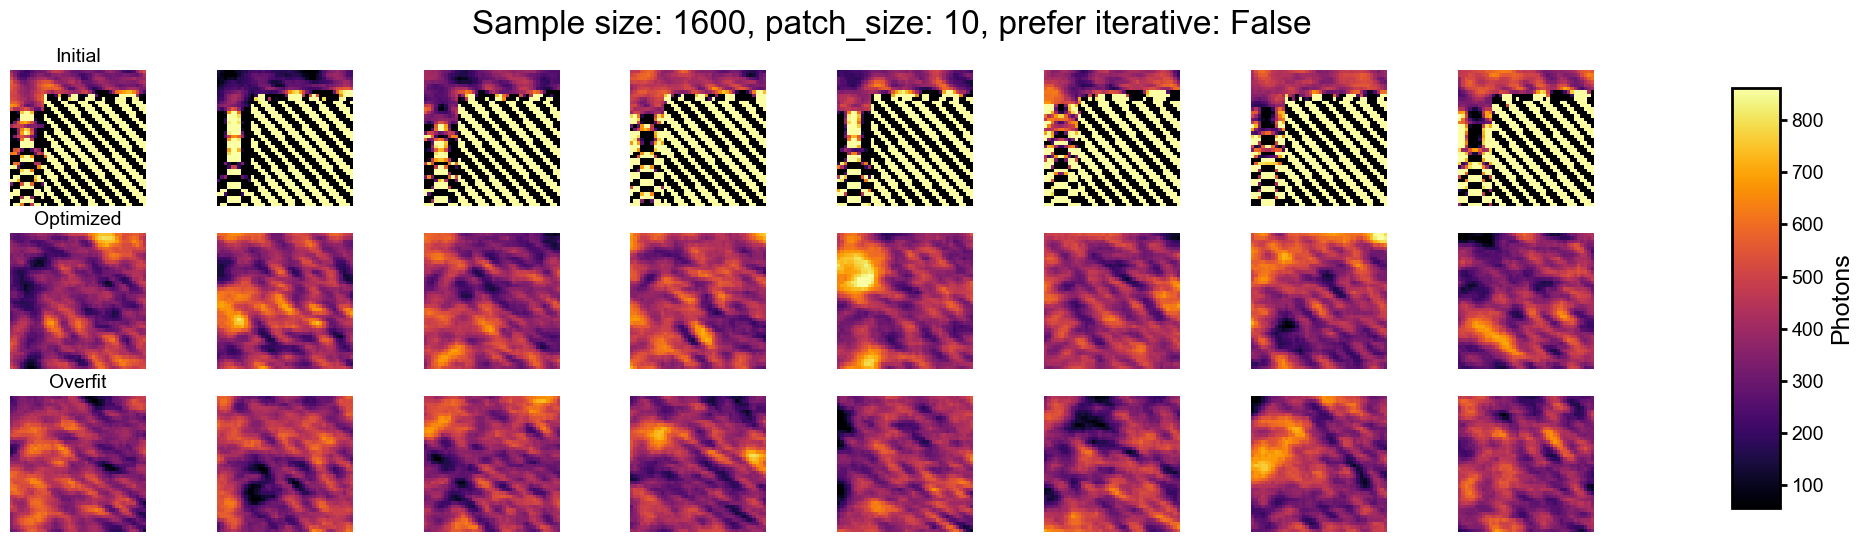

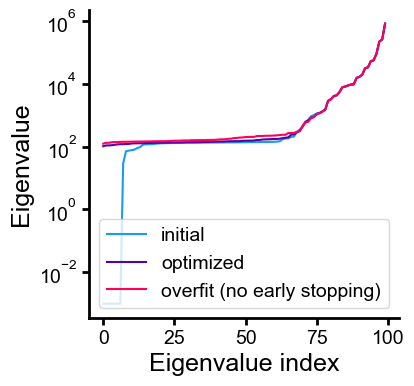

In [7]:
plot_and_print_analysis(initial_likelihood, optimized_likelihood, overfit_likelihood,
                            samples_initial, samples_optimized, samples_overfit, 
                            cov_mat_initial, cov_mat_optimized, final_cov_mat, patch_size, num_samples, prefer_iterative_sampling)

## Does DPC produce the same artifacts? 

In [8]:
# load images, extract patches, and compute cov mats
edge_crop = 32
patch_size = 10
num_images = 20000
channel = 'DPC_Right'
eigenvalue_floor = 1e-3

num_test_images = 1000

all_images = load_bsccm_images(bsccm, channel=channel, num_images=num_images + num_test_images, edge_crop=edge_crop, median_filter=False)
images = all_images[:num_images]
test_images = all_images[num_images:]
test_patches = extract_patches(test_images, patch_size, num_patches=num_test_images, seed=0)

num_patches = 10000 
seed = 10 # this seed gives a bad initial fit
patches = extract_patches(images, patch_size, num_patches=num_patches, seed=seed)

Initial loss:  934370.3004886062


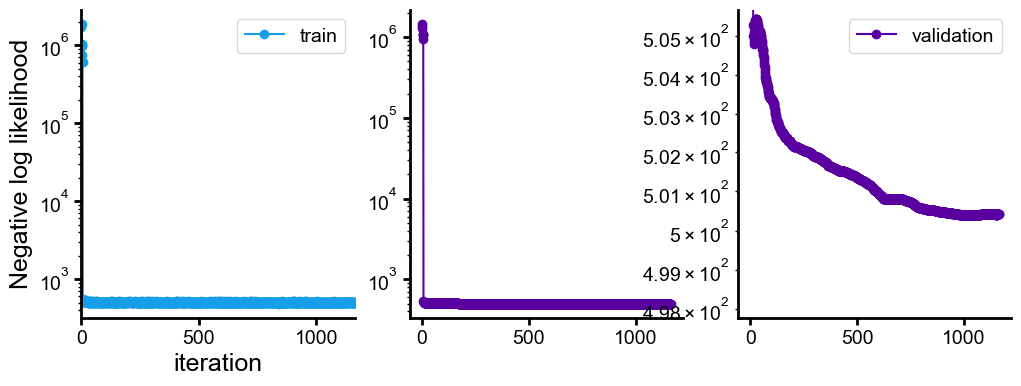

In [9]:
### Do the optimization
cov_mat_optimized, cov_mat_initial, mean_vec, best_loss, train_loss_history, val_loss_history, final_cov_mat = run_optimization(
    patches, max_iters=1500, return_final=True, patience=150)
plot_loss_history(train_loss_history, val_loss_history)

In [10]:
sample_size = 40
num_samples = 8
prefer_iterative_sampling = False

samples_initial = generate_stationary_gaussian_process_samples(mean_vec, cov_mat_initial, num_samples=num_samples, sample_size=sample_size, 
        prefer_iterative_sampling=prefer_iterative_sampling, seed=None)
samples_optimized = generate_stationary_gaussian_process_samples(mean_vec, cov_mat_optimized, num_samples=num_samples, sample_size=sample_size,
        prefer_iterative_sampling=prefer_iterative_sampling,  seed=None)
samples_overfit = generate_stationary_gaussian_process_samples(mean_vec, final_cov_mat, num_samples=num_samples, sample_size=sample_size,
        prefer_iterative_sampling=prefer_iterative_sampling,  seed=None)

optimized_likelihood = compute_stationary_log_likelihood(test_patches, cov_mat_optimized, mean_vec).mean()
initial_likelihood = compute_stationary_log_likelihood(test_patches, cov_mat_initial, mean_vec).mean()
overfit_likelihood = compute_stationary_log_likelihood(test_patches, final_cov_mat, mean_vec).mean()

precomputing masks and variances: 100%|██████████| 40/40 [00:29<00:00,  1.37it/s]


generating samples


precomputing masks and variances: 100%|██████████| 40/40 [00:29<00:00,  1.37it/s]


generating samples


precomputing masks and variances: 100%|██████████| 40/40 [00:29<00:00,  1.37it/s]


generating samples


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 223.54it/s]


evaluating likelihood


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 233.69it/s]


evaluating likelihood


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 201.19it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 10/10 [00:00<00:00, 229.15it/s]


Initial likelihood: -1204064.0745188412
Optimized likelihood: -500.11749556093184
Overfit likelihood: -500.1594265590649


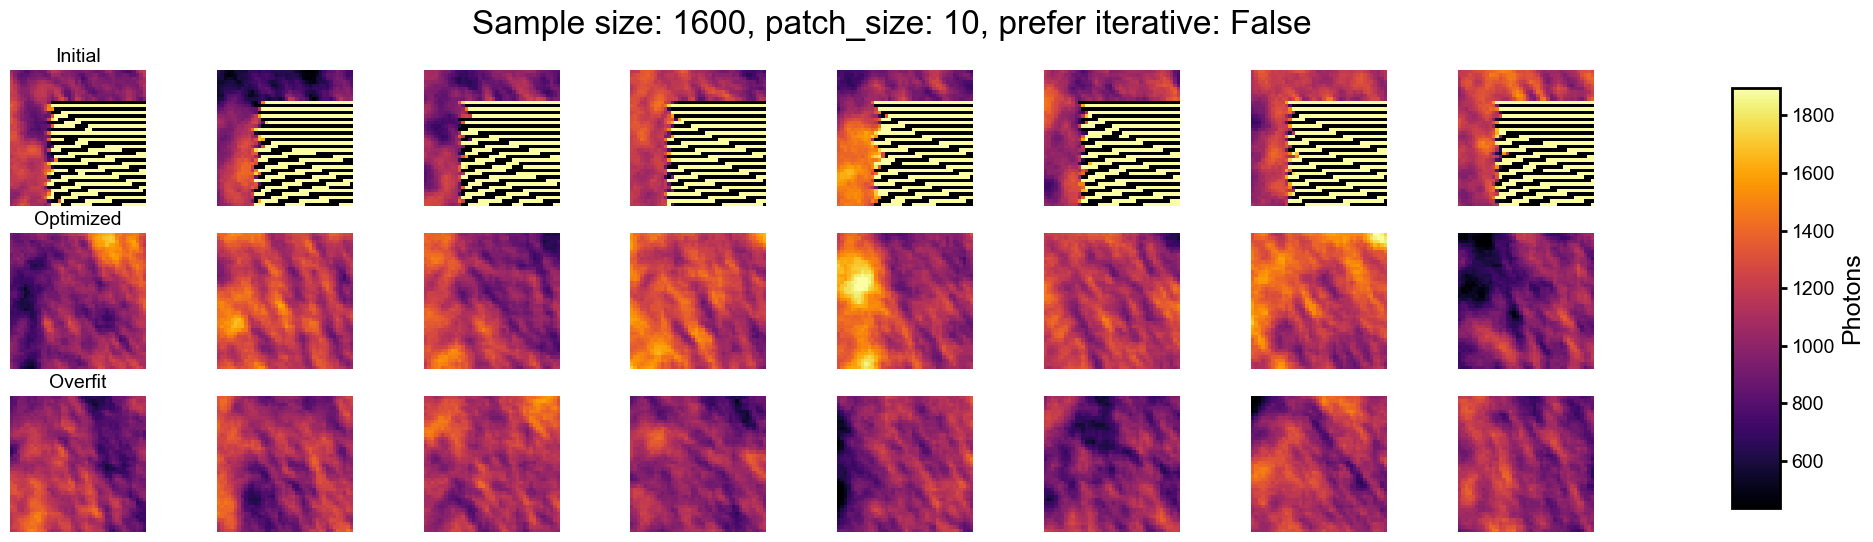

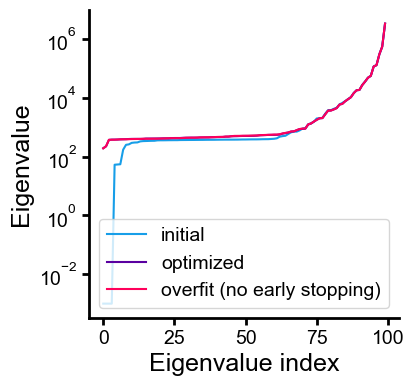

In [11]:
plot_and_print_analysis(initial_likelihood, optimized_likelihood, overfit_likelihood,
                            samples_initial, samples_optimized, samples_overfit, 
                            cov_mat_initial, cov_mat_optimized, final_cov_mat, patch_size, num_samples, prefer_iterative_sampling)

## Same thing when you way overfit to a small number of patches?

In [12]:
# load images, extract patches, and compute cov mats
edge_crop = 32
patch_size = 10
num_images = 1000
channel = 'LED119'
eigenvalue_floor = 1e-3

num_test_images = 1000

all_images = load_bsccm_images(bsccm, channel=channel, num_images=num_images + num_test_images, edge_crop=edge_crop, median_filter=False)
images = all_images[:num_images]
test_images = all_images[num_images:]
test_patches = extract_patches(test_images, patch_size, num_patches=num_test_images, seed=0)

num_patches = 10000 
seed = 10 # this seed gives a bad initial fit
patches = extract_patches(images, patch_size, num_patches=num_patches, seed=seed)



Initial loss:  482.60219800425443


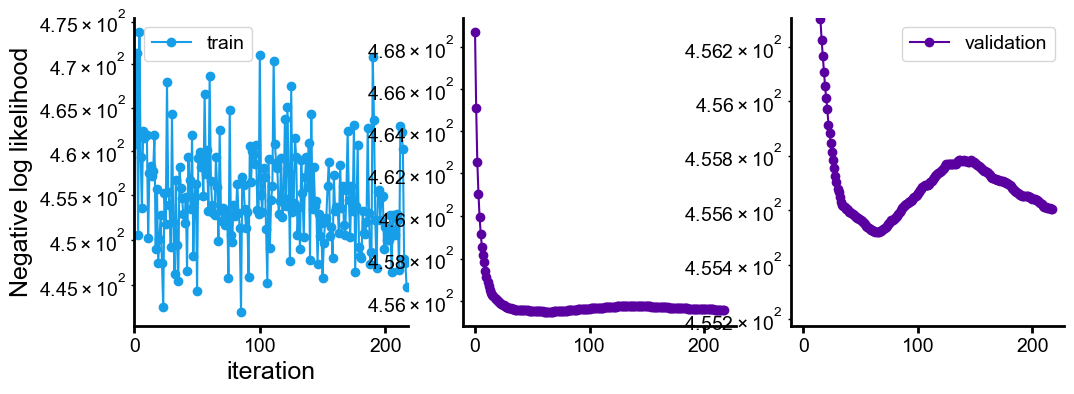

In [13]:
cov_mat_optimized, cov_mat_initial, mean_vec, best_loss, train_loss_history, val_loss_history, final_cov_mat = run_optimization(
    patches, max_iters=1500, return_final=True, patience=150)
plot_loss_history(train_loss_history, val_loss_history)

In [14]:
sample_size = 40
num_samples = 8
prefer_iterative_sampling = False

samples_initial = generate_stationary_gaussian_process_samples(mean_vec, cov_mat_initial, num_samples=num_samples, sample_size=sample_size, 
        prefer_iterative_sampling=prefer_iterative_sampling, seed=None)
samples_optimized = generate_stationary_gaussian_process_samples(mean_vec, cov_mat_optimized, num_samples=num_samples, sample_size=sample_size,
        prefer_iterative_sampling=prefer_iterative_sampling,  seed=None)
samples_overfit = generate_stationary_gaussian_process_samples(mean_vec, final_cov_mat, num_samples=num_samples, sample_size=sample_size,
        prefer_iterative_sampling=prefer_iterative_sampling,  seed=None)

optimized_likelihood = compute_stationary_log_likelihood(test_patches, cov_mat_optimized, mean_vec).mean()
initial_likelihood = compute_stationary_log_likelihood(test_patches, cov_mat_initial, mean_vec).mean()
overfit_likelihood = compute_stationary_log_likelihood(test_patches, final_cov_mat, mean_vec).mean()

precomputing masks and variances:  50%|█████     | 20/40 [00:13<00:15,  1.30it/s]

precomputing masks and variances: 100%|██████████| 40/40 [00:29<00:00,  1.37it/s]


generating samples


precomputing masks and variances: 100%|██████████| 40/40 [00:28<00:00,  1.38it/s]


generating samples


precomputing masks and variances: 100%|██████████| 40/40 [00:29<00:00,  1.37it/s]


generating samples


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 227.08it/s]


evaluating likelihood


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 199.20it/s]


evaluating likelihood


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 206.60it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 10/10 [00:00<00:00, 191.80it/s]


Initial likelihood: -473.7351858894094
Optimized likelihood: -454.8024814439921
Overfit likelihood: -454.91071308962


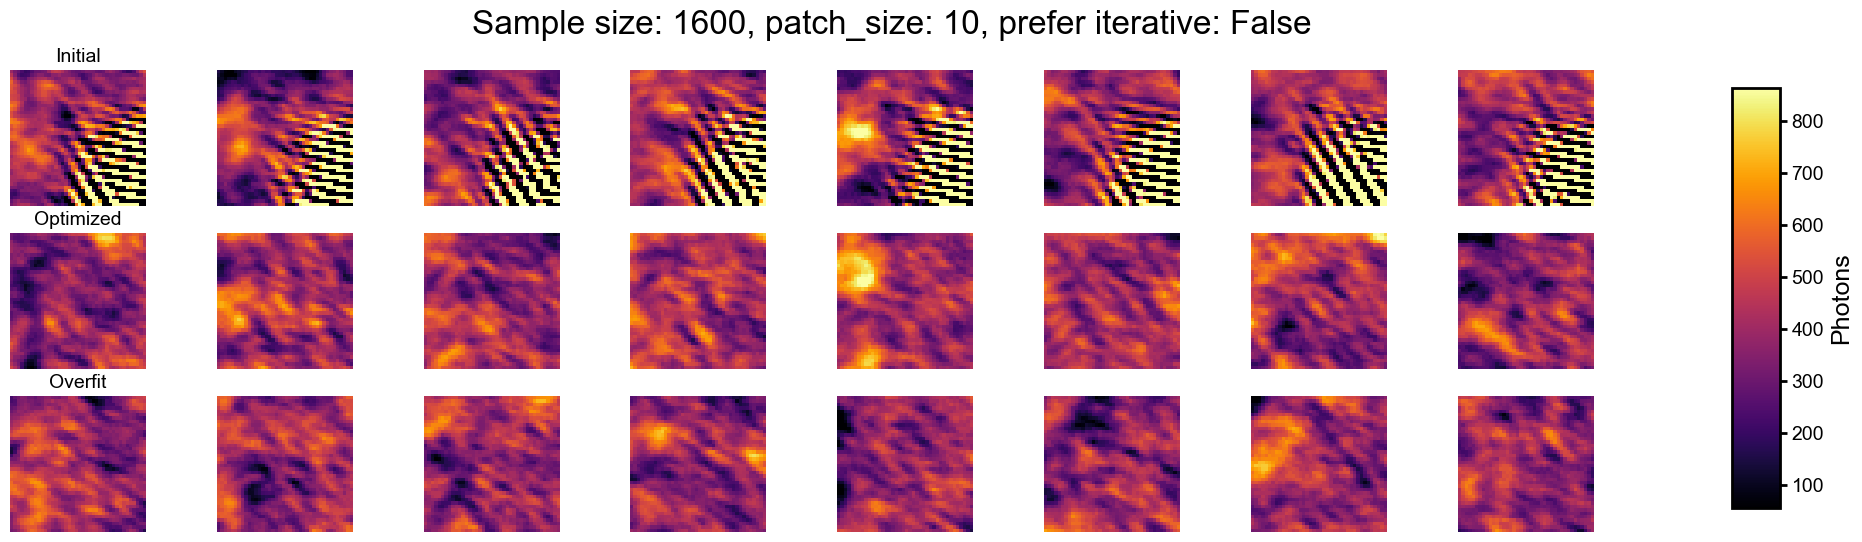

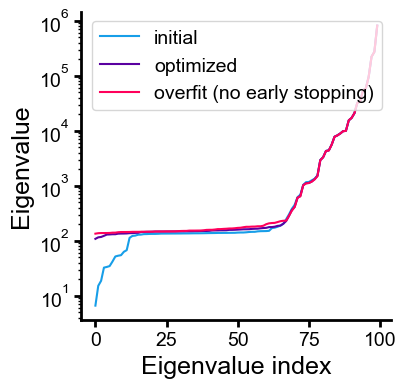

In [15]:
plot_and_print_analysis(initial_likelihood, optimized_likelihood, overfit_likelihood,
                            samples_initial, samples_optimized, samples_overfit, 
                            cov_mat_initial, cov_mat_optimized, final_cov_mat, patch_size, num_samples, prefer_iterative_sampling)

## Can you generate an even bigger patch?

In [16]:
# load images, extract patches, and compute cov mats
edge_crop = 32
patch_size = 10
num_images = 20000
channel = 'LED119'
eigenvalue_floor = 1e-3

num_test_images = 1000

all_images = load_bsccm_images(bsccm, channel=channel, num_images=num_images + num_test_images, edge_crop=edge_crop, median_filter=False)
images = all_images[:num_images]
test_images = all_images[num_images:]
test_patches = extract_patches(test_images, patch_size, num_patches=num_test_images, seed=0)

num_patches = 10000 
seed = 10 # this seed gives a bad initial fit
patches = extract_patches(images, patch_size, num_patches=num_patches, seed=seed)


Initial loss:  686047.1147863457


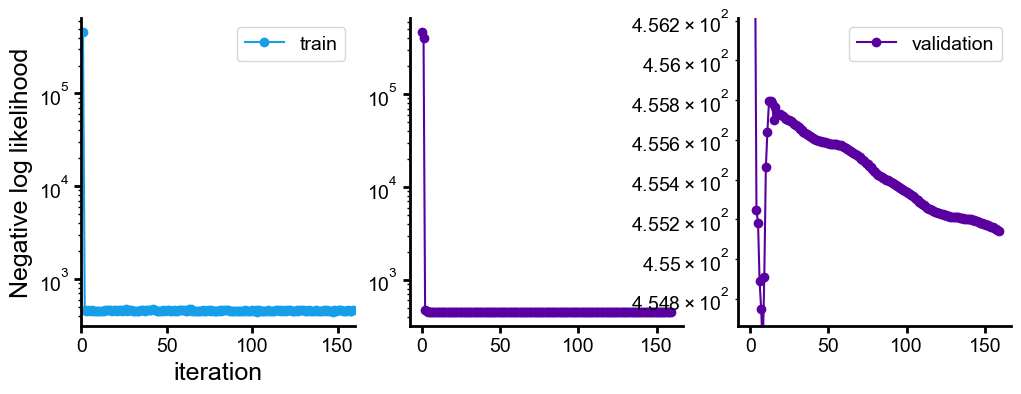

In [17]:
cov_mat_optimized, cov_mat_initial, mean_vec, best_loss, train_loss_history, val_loss_history, final_cov_mat = run_optimization(
    patches, max_iters=1500, return_final=True, patience=150)
plot_loss_history(train_loss_history, val_loss_history)

In [18]:
sample_size = 96
num_samples = 8
prefer_iterative_sampling = False

samples_initial = generate_stationary_gaussian_process_samples(mean_vec, cov_mat_initial, num_samples=num_samples, sample_size=sample_size, 
        prefer_iterative_sampling=prefer_iterative_sampling, seed=None)
samples_optimized = generate_stationary_gaussian_process_samples(mean_vec, cov_mat_optimized, num_samples=num_samples, sample_size=sample_size,
        prefer_iterative_sampling=prefer_iterative_sampling,  seed=None)
samples_overfit = generate_stationary_gaussian_process_samples(mean_vec, final_cov_mat, num_samples=num_samples, sample_size=sample_size,
        prefer_iterative_sampling=prefer_iterative_sampling,  seed=None)

optimized_likelihood = compute_stationary_log_likelihood(test_patches, cov_mat_optimized, mean_vec).mean()
initial_likelihood = compute_stationary_log_likelihood(test_patches, cov_mat_initial, mean_vec).mean()
overfit_likelihood = compute_stationary_log_likelihood(test_patches, final_cov_mat, mean_vec).mean()

precomputing masks and variances: 100%|██████████| 96/96 [02:57<00:00,  1.85s/it]


generating samples


precomputing masks and variances: 100%|██████████| 96/96 [02:57<00:00,  1.85s/it]


generating samples


precomputing masks and variances: 100%|██████████| 96/96 [02:56<00:00,  1.84s/it]


generating samples


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 187.32it/s]


evaluating likelihood


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 210.76it/s]


evaluating likelihood


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 199.26it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 10/10 [00:00<00:00, 204.58it/s]


Initial likelihood: -614612.096021153
Optimized likelihood: -456.89266095620184
Overfit likelihood: -457.33453338011066


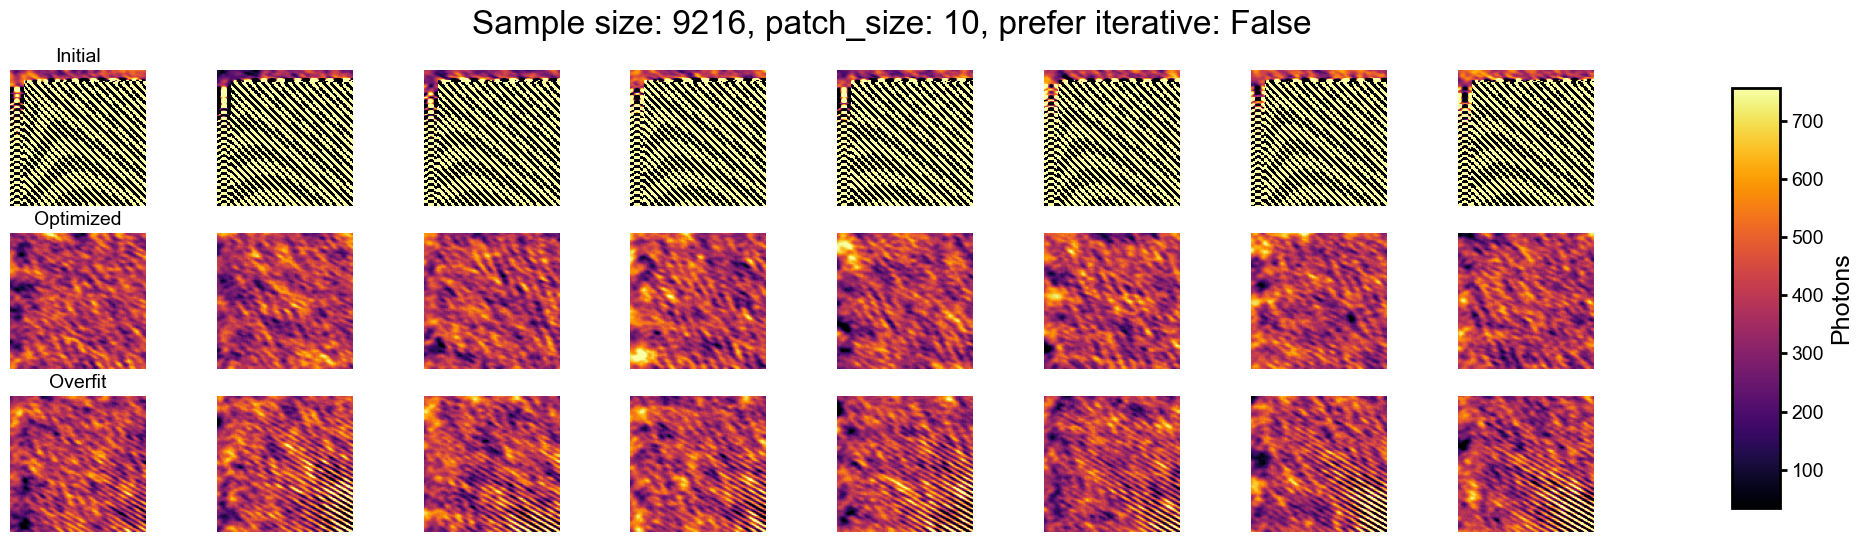

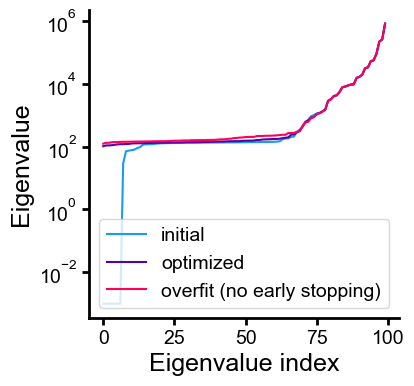

In [19]:
plot_and_print_analysis(initial_likelihood, optimized_likelihood, overfit_likelihood,
                            samples_initial, samples_optimized, samples_overfit, 
                            cov_mat_initial, cov_mat_optimized, final_cov_mat, patch_size, num_samples, prefer_iterative_sampling)

## Repeat from above for longer--double descent??

In [24]:
# load images, extract patches, and compute cov mats
edge_crop = 32
patch_size = 10
num_images = 20000
channel = 'LED119'
eigenvalue_floor = 1e-3

num_test_images = 1000

all_images = load_bsccm_images(bsccm, channel=channel, num_images=num_images + num_test_images, edge_crop=edge_crop, median_filter=False)
images = all_images[:num_images]
test_images = all_images[num_images:]
test_patches = extract_patches(test_images, patch_size, num_patches=num_test_images, seed=0)

num_patches = 10000 
seed = 10 # this seed gives a bad initial fit
patches = extract_patches(images, patch_size, num_patches=num_patches, seed=seed)



Initial loss:  686047.1147863457


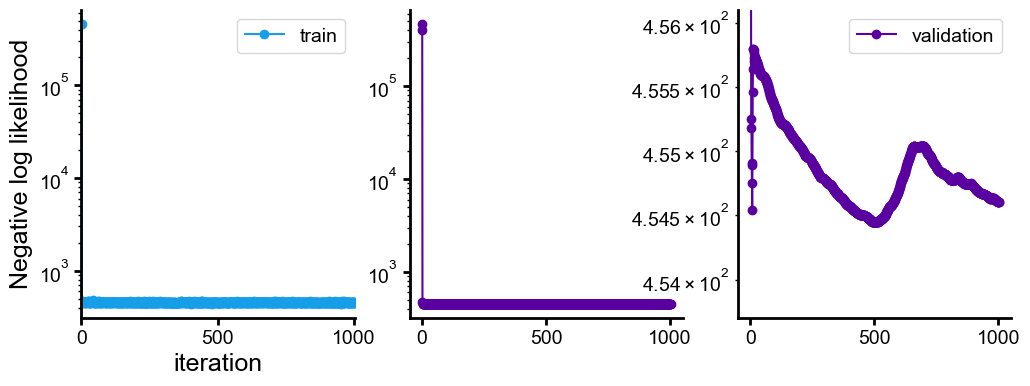

In [25]:
cov_mat_optimized, cov_mat_initial, mean_vec, best_loss, train_loss_history, val_loss_history, final_cov_mat = run_optimization(
    patches, max_iters=2500, return_final=True, patience=500)
plot_loss_history(train_loss_history, val_loss_history)

In [26]:
sample_size = 40
num_samples = 8
prefer_iterative_sampling = False

samples_initial = generate_stationary_gaussian_process_samples(mean_vec, cov_mat_initial, num_samples=num_samples, sample_size=sample_size, 
        prefer_iterative_sampling=prefer_iterative_sampling, seed=None)
samples_optimized = generate_stationary_gaussian_process_samples(mean_vec, cov_mat_optimized, num_samples=num_samples, sample_size=sample_size,
        prefer_iterative_sampling=prefer_iterative_sampling,  seed=None)
samples_overfit = generate_stationary_gaussian_process_samples(mean_vec, final_cov_mat, num_samples=num_samples, sample_size=sample_size,
        prefer_iterative_sampling=prefer_iterative_sampling,  seed=None)

optimized_likelihood = compute_stationary_log_likelihood(test_patches, cov_mat_optimized, mean_vec).mean()
initial_likelihood = compute_stationary_log_likelihood(test_patches, cov_mat_initial, mean_vec).mean()
overfit_likelihood = compute_stationary_log_likelihood(test_patches, final_cov_mat, mean_vec).mean()

precomputing masks and variances:  78%|███████▊  | 31/40 [00:22<00:07,  1.28it/s]

precomputing masks and variances: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


generating samples


precomputing masks and variances: 100%|██████████| 40/40 [00:29<00:00,  1.37it/s]


generating samples


precomputing masks and variances: 100%|██████████| 40/40 [00:29<00:00,  1.37it/s]


generating samples


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 205.94it/s]


evaluating likelihood


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 229.19it/s]


evaluating likelihood


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 224.70it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 10/10 [00:00<00:00, 190.46it/s]


Initial likelihood: -614612.096021153
Optimized likelihood: -456.7382326807034
Overfit likelihood: -456.82500844114156


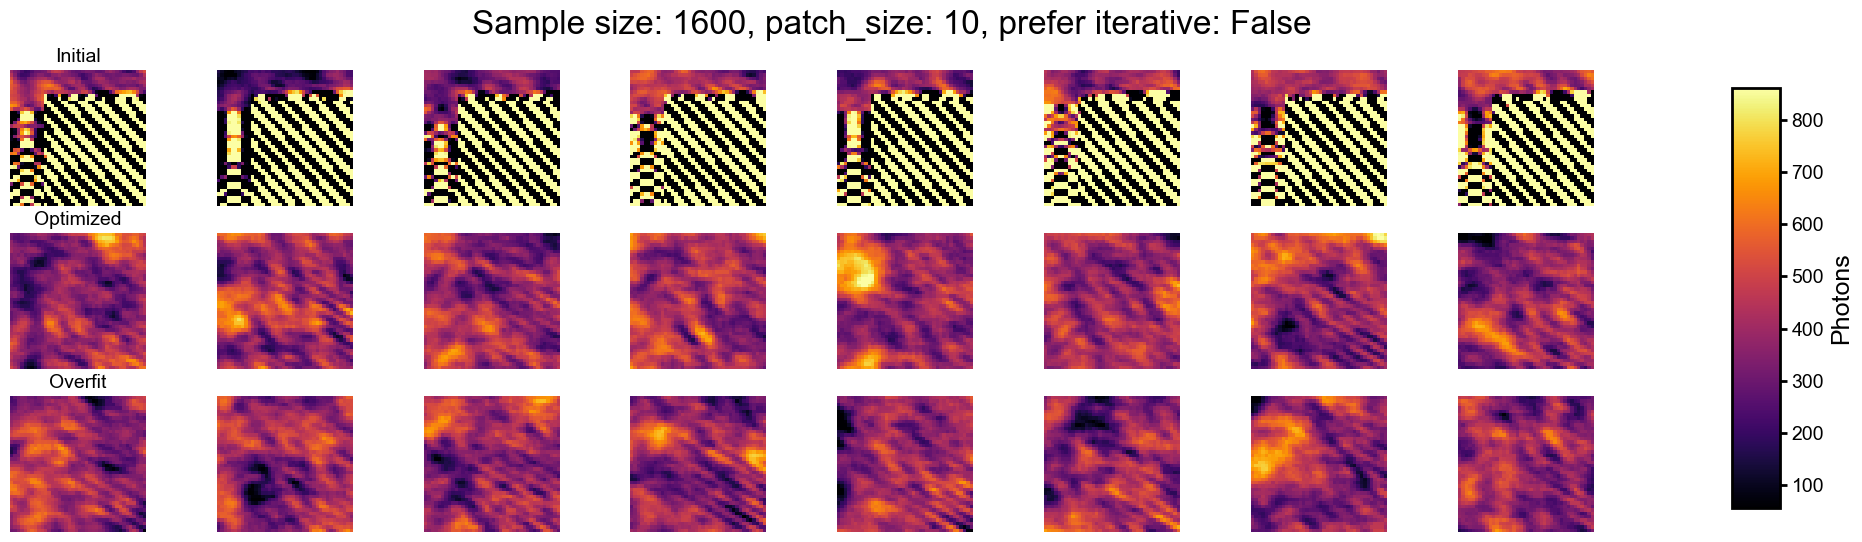

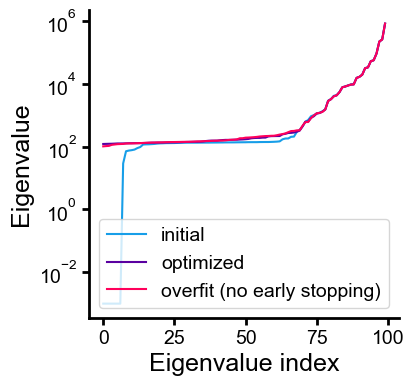

: 

In [27]:
plot_and_print_analysis(initial_likelihood, optimized_likelihood, overfit_likelihood,
                            samples_initial, samples_optimized, samples_overfit, 
                            cov_mat_initial, cov_mat_optimized, final_cov_mat, patch_size, num_samples, prefer_iterative_sampling)